### Axon/dendrite relabeling to improve initial node assignment of neuron reconstruction
* Error correction approach uses the initial segmentation to make a decision based on a larger spatial context.
* A neural network model is trained to predict node labels based on features calculated using the raw image stack and the initial trace.

In [1]:
import os
import numpy as np
import pandas as pd
from neuron_morphology.morphology import Morphology
from neuron_morphology.swc_io import morphology_from_swc, morphology_to_swc
from sklearn.neighbors import KDTree
from scipy.spatial.distance import euclidean
from skimage.morphology import ball
from collections import deque
import tifffile as tif
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

#### Neural network model

In [2]:
class Net(nn.Module):
    def __init__(self, dim1, dim2, dim3, dim4, ch_count1, ch_count2, ch_count3, conv_ksize1,
                 conv_ksize2, conv_ksize3, ksize1, ksize2, ksize3, fcsize):
        super(Net, self).__init__()
        
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        self.dim4 = dim4
        self.ch_count1 = ch_count1
        self.ch_count2 = ch_count2
        self.ch_count3 = ch_count3
        self.ksize1 = ksize1
        self.ksize2 = ksize2
        self.ksize3 = ksize3
        self.conv1 = nn.Conv2d(ch_count1[0], ch_count1[1], conv_ksize1[0], 
                               padding=(conv_ksize1[0][0]//2, conv_ksize1[0][1]//2))
        self.pool1 = nn.MaxPool2d(ksize1[0])
        self.conv2 = nn.Conv2d(ch_count1[1], ch_count1[2], conv_ksize1[1], 
                               padding=(conv_ksize1[1][0]//2, conv_ksize1[1][1]//2))
        self.pool2 = nn.MaxPool2d(ksize1[1])
        self.fc1 = nn.Linear(ch_count1[2]*dim1[0]//ksize1[0][0]//ksize1[1][0]
                             *dim1[1]//ksize1[0][1]//ksize1[1][1], fcsize[0]) 
        self.drop1 = nn.Dropout(p=0.5)
        
        self.conv3 = nn.Conv2d(ch_count2[0], ch_count2[1], conv_ksize2[0], 
                               padding=(conv_ksize2[0][0]//2, conv_ksize2[0][1]//2))
        self.pool3 = nn.MaxPool2d(ksize2[0])
        self.conv4 = nn.Conv2d(ch_count2[1], ch_count2[2], conv_ksize2[1], 
                               padding=(conv_ksize2[1][0]//2, conv_ksize2[1][1]//2))
        self.pool4 = nn.MaxPool2d(ksize2[1])
        self.fc2 = nn.Linear(ch_count2[2]*dim3[0]//ksize2[0][0]//ksize2[1][0]
                             *dim3[1]//ksize2[0][1]//ksize2[1][1], fcsize[1])
        self.drop2 = nn.Dropout(p=0.5)
        
        self.conv5 = nn.Conv1d(ch_count3[0], ch_count3[1], conv_ksize3[0], 
                               padding=(conv_ksize3[0]//2))
        self.pool5 = nn.MaxPool1d(ksize3[0])
        self.conv6 = nn.Conv1d(ch_count3[1], ch_count3[2], conv_ksize3[1], 
                               padding=(conv_ksize3[1]//2))
        self.pool6 = nn.MaxPool1d(ksize3[1])
        self.fc3 = nn.Linear(ch_count3[2]*dim3[0]//ksize3[0]//ksize3[1],
                             fcsize[2]) 
        self.drop3 = nn.Dropout(p=0.5)
        
        self.fc4 = nn.Linear(fcsize[0] + dim2[0] + fcsize[1] + fcsize[2],
                             fcsize[0] + dim2[0] + fcsize[1] + fcsize[2])
        self.fc5 = nn.Linear(fcsize[0] + dim2[0] + fcsize[1] + fcsize[2], 1)
    
    def aug_segment(self, t1, t2, t3, t4):
        if self.training:
            s1 = np.where(t1[:,0,:,0]>0)[0]
            s2 = np.array([len(np.where(s1==i)[0]) for i in range(t1.shape[0])])
            n1 = np.array([np.random.randint(max(s,1)) for s in s2])
            n2 = np.array([min(np.random.randint(n1[i]+200, s2[i]+202), t1.shape[2]) 
                           for i in range(t1.shape[0])])
            t1_aug = torch.zeros_like(t1)
            t2_aug = torch.zeros_like(t2)
            t3_aug = torch.zeros_like(t3)
            t4_aug = torch.zeros_like(t4)
            for i in range(t1.shape[0]):
                t1_aug[i,:,0:n2[i]-n1[i],:] = t1[i,:,n1[i]:n2[i],:]
                t3_aug[i,:,0:n2[i]-n1[i],:] = t3[i,:,n1[i]:n2[i],:]
                t2_aug[i] = t2[i] + n1[i]*np.mean(pxl_xyz)
                t4_aug[i,:,0:n2[i]-n1[i]] = t4[i,:,n1[i]:n2[i]]
            return (t1_aug, t2_aug, t3_aug, t4_aug)
        else:
            return (t1, t2, t3, t4)
    
    def forward(self, x1, x2, x3, x4):
        (x1, x2, x3, x4) = self.aug_segment(x1, x2, x3, x4)
        x1 = self.pool1(F.relu(self.conv1(x1))) 
        x1 = self.pool2(F.relu(self.conv2(x1)))
        x1 = x1.view(-1, self.ch_count1[2]*self.dim1[0]//self.ksize1[0][0]//self.ksize1[1][0]*
                  self.dim1[1]//self.ksize1[0][1]//self.ksize1[1][1])
        x1 = F.relu(self.fc1(x1))
        x1 = self.drop1(x1)
        
        x3 = self.pool3(F.relu(self.conv3(x3)))
        x3 = self.pool4(F.relu(self.conv4(x3)))
        x3 = x3.view(-1, self.ch_count2[2]*self.dim3[0]//self.ksize2[0][0]//self.ksize2[1][0]*
                  self.dim3[1]//self.ksize2[0][1]//self.ksize2[1][1])
        x3 = F.relu(self.fc2(x3))
        x3 = self.drop2(x3)
        
        x4 = self.pool5(F.relu(self.conv5(x4)))
        x4 = self.pool6(F.relu(self.conv6(x4)))
        x4 = x4.view(-1, self.ch_count3[2]*self.dim4[0]//self.ksize3[0]//self.ksize3[1])
        x4 = F.relu(self.fc3(x4))
        x4 = self.drop3(x4)
        
        x = torch.cat((x1,x2,x3,x4), dim=1)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x

#### Functions used to load raw image stack, calculate features, run predictions, and relabel trace

In [3]:
def load_stack_invert(dirname):
    # Load image stack filenames
    filelist = [f for f in os.listdir(dirname) if f.endswith('.tif')] 
    filelist.sort()
    
    # Calculate stack size
    filename = os.path.join(dirname, filelist[0])
    img = tif.imread(filename)
    cell_stack_size = len(filelist), img.shape[0], img.shape[1]
        
    stack = np.zeros(cell_stack_size, dtype=img.dtype)
    for i, f in enumerate(filelist):
        filename = os.path.join(dirname, f)
        img = tif.imread(filename)
        stack[i,:,:] = 255 - img
        
    return stack 

def reroot_tree(start_node, tree, morph):
    # Create neighbors dict
    neighbors_dict = {}
    for node in tree:
        node_neighbors = [] 
        parent = morph.parent_of(node)
        if parent != None:
            node_neighbors.append(parent)
        children = morph.get_children(node)
        for ch in children:
            node_neighbors.append(ch) 
        neighbors_dict[node['id']] = node_neighbors 
    start_node_parent = -1
    # Assign parent-child relation
    parent_dict = {}
    parent_dict[start_node['id']] = start_node_parent
    queue = deque([start_node])
    while len(queue) > 0:
        current_node = queue.popleft()
        neighbors = neighbors_dict[current_node['id']]
        for node in neighbors:
            if node['id'] not in parent_dict:
                parent_dict[node['id']] = current_node['id']
                queue.append(node)
    # Change node parents
    new_tree = copy.deepcopy(tree)
    for node in new_tree:
        node['parent'] = parent_dict[node['id']]
    return new_tree
    
def calculate_features(sp, indir, outdir, pxl_xyz):
    stack = load_stack_invert(os.path.join(indir, str(sp), 'Single_Tif_Images'))
    stack_size = stack.shape
    print('stack', stack_size)
    morph_in = morphology_from_swc(os.path.join(indir, '%d_initial.swc'%sp))
    print('total nodes', len(morph_in.nodes()))
    soma_node = morph_in.get_soma()
    morph_new = copy.deepcopy(morph_in) 
    root_nodes = morph_new.get_roots()
    for node in root_nodes:
        if node['parent'] != -1:
            node['parent'] = -1
    tree_list_new = morph_new.get_tree_list()
    # Find soma tree, disconnect and remove soma node
    if soma_node not in tree_list_new[0]:
        for i, tree in enumerate(tree_list_new):
            if soma_node in tree:
                soma_idx1 = i            
                break
    else:
        soma_idx1 = 0
    tree_soma = tree_list_new[soma_idx1] 
    soma_idx2 = tree_soma.index(soma_node)
    # Disconnect soma node's children from soma
    soma_ch = morph_new.get_children(soma_node)
    for node in soma_ch:
        node['parent'] = -1
    df = pd.DataFrame.from_dict([soma_node] + soma_ch)
    filename = os.path.join(indir, '%d_soma_ch.csv'%sp)
    df.to_csv(filename, index=False)
    # Remove soma node
    if soma_node in tree_soma:
        tree_soma.remove(soma_node)
    # Update morph
    tree_nodes = [node for tree in tree_list_new for node in tree]
    morph_new = Morphology(tree_nodes,
                node_id_cb=lambda node: node['id'],
                parent_id_cb=lambda node: node['parent'])
    morphology_to_swc(morph_new, os.path.join(indir,'%d_no_soma.swc'%sp))
    tree_list_new = morph_new.get_tree_list()
    print('num trees', len(tree_list_new))

    leaf_nodes = morph_new.get_leaf_nodes()
    soma_node_coord = np.array((soma_node['x'], soma_node['y'],
                                soma_node['z']))*pxl_xyz
        
    n_list = [] # nodes
    v_list = [] # brightness
    ds_list = [] # distance to soma
    e_list = [] # tortuosity
    t_list = [] # tree index
    
    # Create kernels for neighborhood
    w = 32
    se_idx = [1, 2, 4, 8, 16, 32]
    idx = np.flip(np.arange(len(se_idx)))
    se_list = []
    for i in se_idx:
        se = np.pad(ball(i), w-i, 'constant')
        se_list.append(se)  
    for i in idx[:-1]:
        se_list[i] = se_list[i] - se_list[i-1]
    num_nodes = [4, 8, 16, 32, 64, 128]
    
    for i, tree in enumerate(tree_list_new):
        root_node = morph_new.get_roots_for_nodes(tree)[0]
        tree_leaf_nodes = [node for node in tree if node in leaf_nodes]
        tree_end_nodes = [root_node] + tree_leaf_nodes    
        end_node_coord = np.array([np.array((node['x'], node['y'],
                                node['z']))*pxl_xyz for node in tree_end_nodes])
        kdtree = KDTree(end_node_coord, leaf_size=2)
        dist, min_dist_idx = kdtree.query(soma_node_coord.reshape(1,3), k=1)
        if min_dist_idx[0][0] > 0:
            tree = reroot_tree(tree_end_nodes[min_dist_idx[0][0]], tree, morph_new)
            tree_list_new[i] = tree
            # Update morph
            tree_nodes = [node for tree in tree_list_new for node in tree]
            morph_new = Morphology(tree_nodes,
                        node_id_cb=lambda node: node['id'],
                        parent_id_cb=lambda node: node['parent'])
            leaf_nodes = morph_new.get_leaf_nodes()
            root_node = morph_new.get_roots_for_nodes(tree)[0]
            tree_leaf_nodes = [node for node in tree if node in leaf_nodes]
        
        # Find longest path
        nodes_list = []
        ct_arr = np.zeros((len(tree_leaf_nodes)))
        for j, node in enumerate(tree_leaf_nodes):
            nodes = [node]
            p_node = morph_new.parent_of(node)
            nodes.append(p_node)
            ct = 1
            while p_node['parent'] != -1:
                p_node = morph_new.parent_of(p_node)
                nodes.append(p_node)
                ct += 1
            nodes_list.append(nodes)
            ct_arr[j] = ct
        ddim = 2048 # if tree length > ddim use 9 longest paths
        if len(tree) < ddim: 
            node_set_number = 1
        else:
            node_set_number = min(len(ct_arr), 9) 
            print('tree', i, len(tree), node_set_number)
        np.random.seed(0)
        ct_arr_sorted = np.flip(np.argsort(ct_arr)) 
        ct_idx = np.copy(ct_arr_sorted)
        ct_idx[0:len(ct_arr)//2] = ct_arr_sorted[np.random.permutation(len(ct_arr)//2)]
        for l in range(node_set_number):    
            node_set = nodes_list[ct_idx[l]]
            node_set.reverse()
            node_set = node_set[0:ddim]
            n_list.append(node_set)
            t_list.append(i) # tree index
            
            nodes_coord = np.array([np.array((node['x'], node['y'], node['z'])) 
                                            for node in node_set])*pxl_xyz

            # Calculate brightness features
            z,y,x = np.round(np.array([np.array((node['z'], node['y'], node['x'])) 
                                    for node in node_set])).astype(int).transpose()
            v = np.zeros((z.shape[0], len(se_list)))
            for j in range(len(z)):
                cutout = stack[max(z[j]-w,0):z[j]+w+1,max(y[j]-w,0):y[j]+w+1,max(x[j]-w,0):x[j]+w+1]
                if cutout.shape != (w*2+1, w*2+1, w*2+1):
                    if z[j]-w < 0:
                        cutout = np.pad(cutout,((-z[j]+w,0),(0,0),(0,0)),'edge')
                    if z[j]+w+1 > stack_size[0]:
                        cutout = np.pad(cutout,((0,z[j]+w+1 - stack_size[0]),(0,0),(0,0)),'edge')
                    if y[j]-w < 0:
                        cutout = np.pad(cutout,((0,0),(-y[j]+w,0),(0,0)),'edge')
                    if y[j]+w+1 > stack_size[1]:
                        cutout = np.pad(cutout,((0,0),(0,y[j]+w+1 - stack_size[1]),(0,0)),'edge')
                    if x[j]-w < 0:
                        cutout = np.pad(cutout,((0,0),(0,0),(-x[j]+w,0)),'edge')
                    if x[j]+w+1 > stack_size[2]:
                        cutout = np.pad(cutout,((0,0),(0,0),(0,x[j]+w+1 - stack_size[2])),'edge') 

                for k in range(len(se_list)):
                    v[j,k] = np.sum(cutout*se_list[k])/np.sum(se_list[k])
            v_list.append(v) 

            # Calculate distance to soma and tortuosity features
            ds = np.zeros((nodes_coord.shape[0], ))
            e = np.zeros((nodes_coord.shape[0], len(num_nodes)))
            for j in range(nodes_coord.shape[0]):
                ds[j] = euclidean(nodes_coord[j], soma_node_coord)
                for k, n in enumerate(num_nodes):
                    if j+n < nodes_coord.shape[0]:
                        edist = euclidean(nodes_coord[j], nodes_coord[j+n])
                        path_length = 0.0
                        for m in range(n):
                            path_length += euclidean(nodes_coord[j+m], nodes_coord[j+m+1])
                        e[j,k] = path_length/edist   
            ds_list.append(ds)
            e_list.append(e)        
        
    # Save brightness features
    data = []
    for i, nodes in enumerate(n_list):
        for j, node in enumerate(nodes):
            d = {}
            d['id'], d['type'], d['x'], d['y'], d['z'], d['r'], d['pid'], d['idx'], \
            d['tree'] = node['id'], node['type'], node['x'], node['y'], \
            node['z'], node['radius'], node['parent'], i, t_list[i]
            for k in range(len(se_idx)): 
                d['v%d'%k] = v_list[i][j,k]
            d['ds'] = ds_list[i][j]
            for k in range(len(num_nodes)):
                d['e%d'%k] = e_list[i][j,k]
            data.append(d) 
    df = pd.DataFrame.from_dict(data)
    filename = os.path.join(indir, '%d_features.csv'%sp)
    df.to_csv(filename, index=False)

def load_features(fname, pxl_xyz):
    df = pd.read_csv(fname)
    idx = df['idx'].values
    idx_unique = np.unique(idx)
    print('# of segments', len(idx_unique))
    f1 = ['v%d'%i for i in range(6)]
    f2 = ['ds']
    f3 = ['e%d'%i for i in range(6)]
    f4 = ['type']
    v_values = df[f1].values
    d_values = (df[f2].values).reshape(-1)
    e_values = df[f3].values
    t_values = (df[f4].values).reshape(-1) - 2
    tree_values = df['tree'].values
    data1_list = []
    data2_list = []
    data3_list = []
    data4_list = []
    label_list = []
    tree_list = []
    for i in idx_unique:
        s1 = np.where(idx==i)[0]
        data1_list.append(v_values[s1])
        data2_list.append(d_values[s1][0])
        data3_list.append(e_values[s1])
        data4_list.append(t_values[s1])
        tree_list.append(tree_values[s1][0])    
    tree_idx = np.array(tree_list)
    ddim = 2048
    dthresh = 100
    for i, d1 in enumerate(data1_list):
        d3 = data3_list[i]
        d4 = data4_list[i]
        dist_pxl = int(round(data2_list[i]/np.mean(pxl_xyz)))
        n = int(max(dthresh-dist_pxl,0))
        d1 = d1[n:,:]
        d3 = d3[n:,:]
        d4 = d4[n:]
        if n > 0:
            data2_list[i] = dthresh*np.mean(pxl_xyz)    
        if d1.shape[0] < ddim:
            d1 = np.pad(d1, ((0, ddim - d1.shape[0]),(0,0)), 'constant')
            d3 = np.pad(d3, ((0, ddim - d3.shape[0]),(0,0)), 'constant')
            d4 = np.pad(d4, (0, ddim - d4.shape[0]), 'constant')
        elif d1.shape[0] > ddim:
            d1 = d1[0:ddim,:]
            d3 = d3[0:ddim,:]
            d4 = d4[0:ddim]
        data1_list[i] = d1
        data3_list[i] = d3
        data4_list[i] = d4
    data1 = np.stack(data1_list,0)
    data2 = np.array(data2_list).reshape(-1,1)
    data3 = np.stack(data3_list,0)
    data4 = np.stack(data4_list,0)
    
    return data1, data2, data3, data4, tree_idx            

def predict_labels(sp, indir, outdir, model_path, Net, pxl_xyz):
    # Load features
    fname = os.path.join(indir, '%d_features.csv'%sp)
    data1, data2, data3, data4, tree_idx = load_features(fname, pxl_xyz)
    
    # Run prediction using cpu
    # Setup model
    dim_in1 = data1.shape[1:] 
    dim_in2 = data2.shape[1:] 
    dim_in3 = data3.shape[1:] 
    dim_in4 = data4.shape[1:] 
    channel_count1 = (1, 4, 8)
    channel_count2 = (1, 4, 8)
    channel_count3 = (1, 4, 8)
    conv_kernel_size1 = [(7, 3), (7, 3)] 
    kernel_size1 = [(4, 1), (4, 1)] 
    conv_kernel_size2 = [(7, 3), (7, 3)] 
    kernel_size2 = [(4, 1), (4, 1)]  
    conv_kernel_size3 = [7, 7] 
    kernel_size3 = [4, 4] 
    fc_size = [192, 192, 32] 
    num_class = 1 
    bat_size = 1024
    model = Net(dim1=dim_in1, dim2=dim_in2, dim3=dim_in3, dim4=dim_in4, 
        ch_count1=channel_count1, ch_count2=channel_count2, ch_count3=channel_count3,
        conv_ksize1=conv_kernel_size1, conv_ksize2=conv_kernel_size2,
        conv_ksize3=conv_kernel_size3, ksize1=kernel_size1, 
        ksize2=kernel_size2, ksize3=kernel_size3, fcsize=fc_size)   
    # Load model
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    # Load data
    tensor1 = torch.from_numpy(np.expand_dims(data1, axis=1)).type(torch.FloatTensor)
    tensor2 = torch.from_numpy(data2).type(torch.FloatTensor)
    tensor3 = torch.from_numpy(np.expand_dims(data3, axis=1)).type(torch.FloatTensor)
    tensor4 = torch.from_numpy(np.expand_dims(data4, axis=1)).type(torch.FloatTensor)
    data_set = torch.utils.data.TensorDataset(tensor1, tensor2, tensor3, tensor4)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=bat_size, shuffle=False)

    # Run prediction
    model.eval()
    pred_all = torch.zeros(0, dtype=torch.float)
    with torch.no_grad():
        for i, (inputs1, inputs2, inputs3, inputs4) in enumerate(data_loader): 
            outputs = model(inputs1, inputs2, inputs3, inputs4)
            pred_all = torch.cat((pred_all,outputs)) #outputs.cpu()
    prediction = pred_all.numpy()
      
    # Save prediction as csv file
    prediction = 1/(1+np.exp(-prediction.squeeze()))
    idx = np.arange(len(prediction))
    d = {'idx': idx, 'tree': tree_idx, 'prediction': prediction}
    df = pd.DataFrame.from_dict(d)
    df.to_csv(os.path.join(outdir, '%d_prediction.csv'%sp), index=False)

def relabel_swc(sp, indir, outdir, threshold=0.6):
    # Load swc file (morph without soma node)
    fname = os.path.join(indir, '%d_no_soma.swc'%sp)
    morph_in = morphology_from_swc(fname)
    tree_list = morph_in.get_tree_list()
    
    # Load prediction file
    fname = os.path.join(outdir, '%d_prediction.csv'%sp)
    df = pd.read_csv(fname)
    tree_idx = df['tree'].values
    prediction = df['prediction'].values
    pred = (prediction > threshold).astype(np.uint8)
    
    # Relable segments
    for i, tree in enumerate(tree_list):
        s1 = np.where(tree_idx==i)[0]
        if len(s1) == 1:
            tree_node_type = pred[s1][0]
        else:
            tree_node_type = int(min(np.mean(prediction[s1]), np.mean(pred[s1])) > threshold)
        for node in tree:
            node['type'] = tree_node_type + 2 # 0-axon, 1-dendrite
    tree_nodes = [node for tree in tree_list for node in tree]
    
    # Add soma node
    fname = os.path.join(indir, '%d_soma_ch.csv'%sp)
    df = pd.read_csv(fname)
    soma_node = {'id': int(df.iloc[0]['id']), 'type': int(df.iloc[0]['type']), 
                 'x': df.iloc[0]['x'], 'y': df.iloc[0]['y'], 'z': df.iloc[0]['z'], 
                 'radius': df.iloc[0]['radius'], 'parent': int(df.iloc[0]['parent'])}
    tree_nodes = [soma_node] + tree_nodes
    
    # Connect soma children
    if len(df['id'].values) > 1:
        soma_ch_id = df['id'].values[1:]
        for node in tree_nodes:
            if node['id'] in soma_ch_id:
                node['parent'] = soma_node['id']
    else:
        print('no soma children')
       
    morph_out = Morphology(tree_nodes, 
                           node_id_cb=lambda node: node['id'], 
                           parent_id_cb=lambda node: node['parent'])

    morphology_to_swc(morph_out, os.path.join(outdir, '%d_relabeled.swc'%sp))
    
def load_swc(filepath):
    '''
    Load swc file as a N X 7 numpy array
    '''
    swc = []
    with open(filepath) as f:
        lines = f.read().split("\n")
        for l in lines:
            if not l.startswith('#'):
                cells = l.split(' ')
                if len(cells) == 7:
                    cells = [float(c) for c in cells]
                    swc.append(cells)
                elif len(cells) == 8:
                    cells = [float(c) for c in cells[0:7]]
                    swc.append(cells)                
    return np.array(swc)    

#### Running relabeling of initial trace using pre-trained model

In [4]:
rootdir = '../..'
datadir = os.path.join(rootdir, 'data')
specimen_id = 861765455
input_dir = os.path.join(datadir, 'dataset', 'relabeling')
output_dir = os.path.join(rootdir, 'results') 
pxl_xyz = np.array([0.1144, 0.1144, 0.28])
model_file = os.path.join(datadir, 'models', 'relabeling', 'fold0_best.model')

#### Step1. Calculate features


In [5]:
# Skip this step since it requires raw image stack with size 9GB, use file with pre-calculated features instead
# calculate_features(specimen_id, input_dir, output_dir, pxl_xyz)

#### Step2. Predict segments' labels

In [6]:
predict_labels(specimen_id, input_dir, output_dir, model_file, Net, pxl_xyz)

# of segments 246


#### Step3. Relabel segments based on prediction

In [7]:
relabel_swc(specimen_id, input_dir, output_dir)

#### Plot manual vs auto initial vs auto relabeled trace

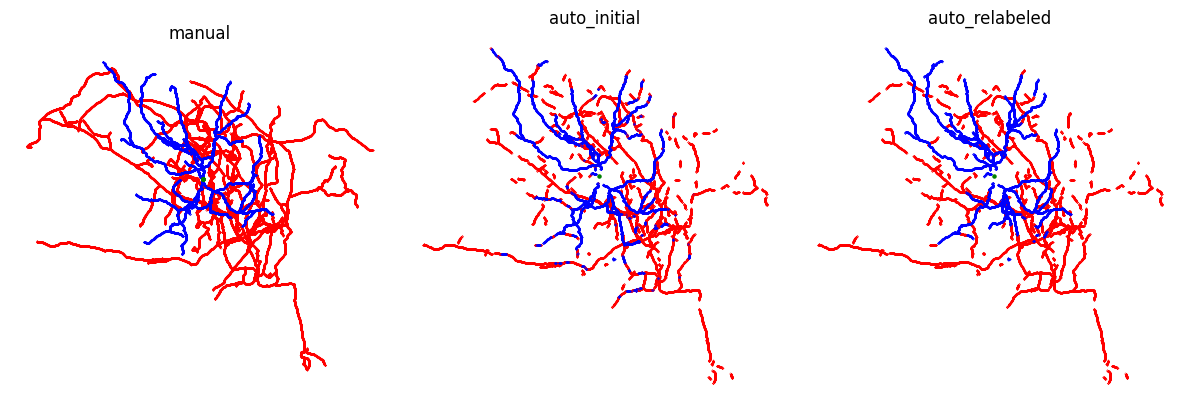

In [8]:
file_list = [os.path.join(input_dir, '%d_manual.swc'%specimen_id),
            os.path.join(input_dir, '%d_initial.swc'%specimen_id),
            os.path.join(output_dir, '%d_relabeled.swc'%specimen_id)]

color_dict = {'1': 'g', '2': 'r', '3': 'b', '5': 'k'}
trace_list = []
for f in file_list:
    trace_list.append(load_swc(f))

tlist = ['manual', 'auto_initial', 'auto_relabeled']
plt.figure(figsize=(12,4))
for i, trace in enumerate(trace_list):
    plt.subplot(1,3,i+1)
    sa = np.where(trace[:,1]==2)
    plt.scatter(trace[sa,2], trace[sa,3], marker = '.', c='r', s=0.1)
    sd = np.where(trace[:,1]==3)
    plt.scatter(trace[sd,2], trace[sd,3], marker = '.', c='b', s=0.1)
    ss = np.where(trace[:,1]==1)
    plt.scatter(trace[ss,2], trace[ss,3], marker = '.', c='g', s=20)
    plt.ylim(plt.ylim()[::-1])
    plt.axis('scaled')
    plt.axis('off')
    plt.title(tlist[i])
plt.tight_layout()
plt.show()    